# Utils

### Libraries

In [1]:
import pandas as pd
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
import umap
import statsmodels.api as sm
import warnings
import sys
import numpy as np
from sklearn.metrics import silhouette_score
from scipy.optimize import linear_sum_assignment
from scipy.stats import chi2_contingency
from scipy.stats import kruskal
import scikit_posthocs as sp

In [2]:
# Suppress all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("/Users/emmatosato/Documents/PhD/ANM_Verona/src/data_processing")

In [3]:
import importlib
from data_processing import umap_clustering, umap_regression, clustering_evaluation, umap_run, processing_flat

importlib.reload(clustering_evaluation)
importlib.reload(umap_regression)
importlib.reload(umap_clustering)
importlib.reload(umap_run)
importlib.reload(processing_flat)

from data_processing.clustering_evaluation import evaluate_kmeans, evaluate_gmm, evaluate_hdbscan, evaluate_consensus
from data_processing.umap_regression import main_regression, plot_ols_diagnostics, remove_missing_values
from data_processing.umap_clustering import main_clustering
from data_processing.processing_flat import main_processing_flat

### Paths and folders

In [4]:
# FC maps mean
dir_FCmaps = '/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps'
dir_FCmaps_processed = '/data/FCmaps_augmented_processed'
dir_data_utils = "/Users/emmatosato/Documents/PhD/ANM_Verona/data_utils/"
gm_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/GM_mask.nii'
harvard_oxford_mask_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/masks/mask_GM.nii'
atrophy_dataset_matches = '/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/atrophy_matched.xlsx'
cognitive_dataset ='/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/cognitive_dataset.xlsx'

# Data

## Raw data

#### One file example

In [5]:
# Load an image
path_temp = os.path.join(dir_FCmaps, '1_S_5005.FDC.nii.gz')
img = nib.load(path_temp)

# Separate the data and affine
temp_img = img.get_fdata()      # 3D volume data
temp_affine = img.affine        # 4x4 affine matrix

# Print shapes
print(temp_img.shape)
print(temp_affine.shape)

(91, 109, 91)
(4, 4)


#### Load data

Function for listing the data in nii.gz format and extract the subjects identifiers + printing some infos

In [6]:
def listData_saveID(dir):
    # All nii.gz files in the directory
    files_path = sorted(glob.glob(os.path.join(dir, '*gz')))

    # Extract Subject IDs from filenames
    subject_id = [os.path.basename(f).replace('.FDC.nii.gz', '') for f in files_path]

    # Sanity checks
    assert len(files_path) == len(subject_id), (
        f"Mismatch count: {len(files_path)} files vs {len(subject_id)} IDs"
    )
    assert len(subject_id) == len(set(subject_id)), "ID duplicated"
    for fp, sid in zip(files_path, subject_id):
        fname = os.path.basename(fp)
        expected = sid + '.FDC.nii.gz'
        assert fname == expected, (
            f"Filename “{fname}” do not correspond to the extracted ID“{sid}”"
        )

    print("Check length:")
    print("Files: ", len(files_path))
    print("Subject: ", len(subject_id))

    return files_path, subject_id

In [7]:
files, sub_id = listData_saveID(dir_FCmaps)

Check length:
Files:  176
Subject:  176


In [8]:
maps_FDC = []
for path in files:
    print(path)
    data = nib.load(path).get_fdata().flatten()
    maps_FDC.append(data)

# Stores subjects as rows and voxels as columns
df=pd.DataFrame(maps_FDC)

/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_4654.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/002_S_6695.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6264.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6268.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6432.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6479.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/003_S_6606.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6252.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/006_S_6682.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/007_S_6341.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_4893.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/011_S_6303.FDC.nii.gz
/Users/emmatosato/Documents/PhD/ANM_Verona/data/FCmaps/012_S_4188.FDC.nii.gz

In [9]:
# Copy without id
df_eda = df.copy()

In [10]:
# Insert subjects id
df.insert(0, 'ID', sub_id)
print("\n", df.shape, "\n")


 (176, 902630) 



Some asserts

In [11]:
# 1Ensure the EDA copy has one row per file
assert df_eda.shape[0] == len(files), (
    f"Rows in df_eda ({df_eda.shape[0]}) != number of files ({len(files)})"
)

# Ensure the df has one row per subject ID
assert df.shape[0] == len(sub_id), (
    f"Number of rows ({df.shape[0]}) != number of IDs ({len(sub_id)})"
)

# Verify the ID column matches the original sub_id order exactly
assert df['ID'].tolist() == sub_id, "Row IDs do not match the original sub_id order"

# Confirm there are no duplicate IDs
assert df['ID'].is_unique, "There are duplicate IDs in the DataFrame"

# Check that inserting the ID column did not alter the numeric data
numeric_equal = (df.drop('ID', axis=1).values == df_eda.values).all()
assert numeric_equal, "Numeric data was altered when inserting the ID column"

#### EDA

In [12]:
print(f"Shape of the dataframes: {df_eda.shape}")

Shape of the dataframe: (176, 902629)


In [13]:
# Global Statistics
all_voxels = df_eda.values.flatten()
all_voxels = all_voxels[~np.isnan(all_voxels)]

# Descriptive statistics
stats_summary = {
    "Min": np.min(all_voxels),
    "Max": np.max(all_voxels),
    "Mean": np.mean(all_voxels),
    "Std": np.std(all_voxels),
    "1st Percentile": np.percentile(all_voxels, 1),
    "25th Percentile": np.percentile(all_voxels, 25),
    "Median (50th)": np.percentile(all_voxels, 50),
    "75th Percentile": np.percentile(all_voxels, 75),
    "99th Percentile": np.percentile(all_voxels, 99),
}

df_stats = pd.DataFrame.from_dict(stats_summary, orient='index', columns=['Value'])
print(df_stats)

                    Value
Min             -0.549580
Max              1.618776
Mean             0.021996
Std              0.056745
1st Percentile  -0.013393
25th Percentile  0.000000
Median (50th)    0.000000
75th Percentile  0.008759
99th Percentile  0.269354


## Metadata

Dataset containing:
- ID of the subject
- The diagnosis (Group)
- Sex
- Age
- Education

The regressors:
- CDR_SB: disease gravity with a larger range
- CDR: same but smaller range

In [14]:
# Load the metadata and align to FC map order
df_meta = pd.read_excel(cognitive_dataset, sheet_name='Sheet1')
df_meta['Age'] = df_meta['Age'].round(1)

In [15]:
df_meta.head(5)

,ID,Group,Sex,Age,Education,CDR_SB,MMSE
0,002_S_4654,ADNI,F,80.4,18,1.5,27.0
1,002_S_6695,ADNI,M,66.3,18,4.5,25.0
2,003_S_6264,ADNI,M,58.3,12,2.5,23.0
3,003_S_6268,ADNI,M,71.6,20,0.5,29.0
4,003_S_6432,ADNI,F,67.3,18,0.5,30.0


#### EDA on Labels

In [16]:
print("Meta dataset BEFORE removing a subject")
print(df_meta.shape)

# Remove the subject with ID "4_S_5003"
df_meta = df_meta[df_meta['ID'] != '4_S_5003'].reset_index(drop=True)

print("Meta dataset AFTER removing a subject")
print(df_meta.shape)

Meta dataset BEFORE removing a subject
(177, 7)
Meta dataset AFTER removing a subject
(176, 7)


In [17]:
# Saving the new csv
df_meta.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/metadata/labels.csv", index=False)

General info

In [18]:
print(df_meta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         176 non-null    object 
 1   Group      176 non-null    object 
 2   Sex        176 non-null    object 
 3   Age        176 non-null    float64
 4   Education  176 non-null    int64  
 5   CDR_SB     171 non-null    float64
 6   MMSE       168 non-null    float64
dtypes: float64(3), int64(1), object(3)
memory usage: 9.8+ KB
None


Missing values

In [19]:
print("\nMissing values for column:")
print(df_meta.isna().sum())


Missing values for column:
ID           0
Group        0
Sex          0
Age          0
Education    0
CDR_SB       5
MMSE         8
dtype: int64


Unique values WITH NaN

In [20]:
print("\nUnique Values:")
print("Group:", sorted(df_meta['Group'].unique()))
print("CDR_SB:", np.sort(df_meta['CDR_SB'].unique()))
print("MMSE:", np.sort(df_meta['MMSE'].unique()))


Unique Values:
Group: ['ADNI', 'CBS', 'PSP']
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18.   nan]
MMSE: [ 4.  5.  8.  9. 10. 11. 12. 14. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30. nan]


Unique values WITHOUT NaN

In [21]:
cdr_sb_no_nan = df_meta['CDR_SB'].dropna()
mmse_no_nan = df_meta['MMSE'].dropna()

In [22]:
print("\nUnique Values:")
print("CDR_SB:", np.sort(cdr_sb_no_nan.unique()))
print("MMSE:", np.sort(mmse_no_nan.unique()))


Unique Values:
CDR_SB: [ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   9.   9.5 10.  11.  12.  13.5 14.  15.  16.  18. ]
MMSE: [ 4.  5.  8.  9. 10. 11. 12. 14. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25.
 26. 27. 28. 29. 30.]


In [23]:
print(df_meta.select_dtypes(include='number').describe().round(1))

         Age  Education  CDR_SB   MMSE
count  176.0      176.0   171.0  168.0
mean    70.9       15.8     4.1   24.1
std      8.4        3.5     3.4    5.0
min     53.0        2.0     0.0    4.0
25%     64.0       14.0     1.5   22.0
50%     71.2       16.0     3.5   25.0
75%     76.0       18.0     6.0   28.0
max     93.8       27.0    18.0   30.0


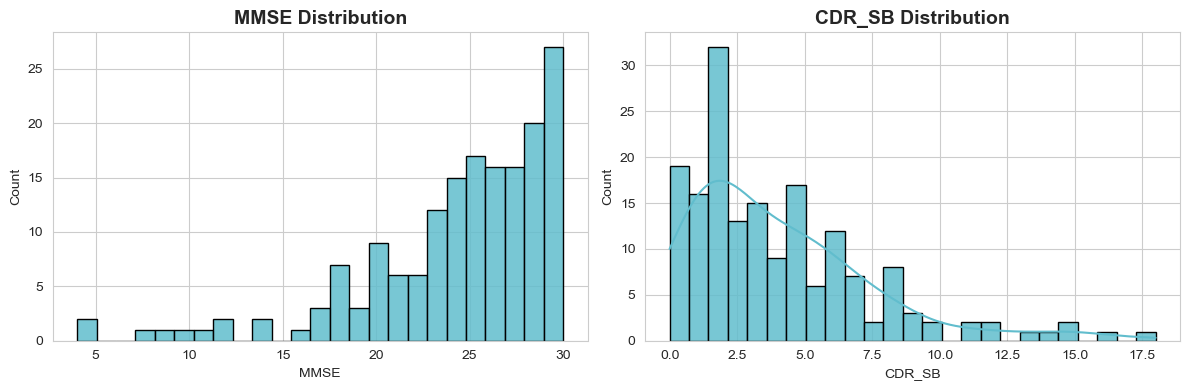

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(mmse_no_nan, bins=25, ax=axes[0], color='#61bdcd', edgecolor='black', alpha=0.85)
axes[0].set_title("MMSE Distribution", fontsize=14, weight='bold')

sns.histplot(cdr_sb_no_nan, bins=25, ax=axes[1], color='#61bdcd', edgecolor='black', alpha=0.85, kde=True)
axes[1].set_title("CDR_SB Distribution", fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

#### GMM on CDR_SB

- Assigning each CDB_SB value to a cluster using GMM, removing NaN values before
- New column for the metadata dataframe

In [25]:
# Filter valid CDR_SB values
df_cdr = df_meta[['ID', 'CDR_SB']].dropna().copy()
print("Dimensions after dropping NaN", df_cdr.shape)

# Fit GMM and predict raw labels
np.random.seed(42)
x_gmm = df_cdr['CDR_SB'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=3, random_state=42).fit(x_gmm)
df_cdr['GMM_Label'] = gmm.predict(x_gmm)

# Reorder labels by CDR_SB severity
means = df_cdr.groupby('GMM_Label')['CDR_SB'].mean().sort_values()
label_map = {old: new for new, old in enumerate(means.index)}
df_cdr['GMM_Label'] = df_cdr['GMM_Label'].map(label_map)

# Include in metadata
label_map = dict(zip(df_cdr['ID'], df_cdr['GMM_Label']))
df_meta = df_meta.drop(columns=['GMM_Label'], errors='ignore')
df_meta['GMM_Label'] = df_meta['ID'].map(label_map).astype('Int64')

Dimensions after dropping NaN (171, 2)


In [26]:
print(df_meta['GMM_Label'].value_counts().sort_index())

GMM_Label
0    80
1    76
2    15
Name: count, dtype: Int64


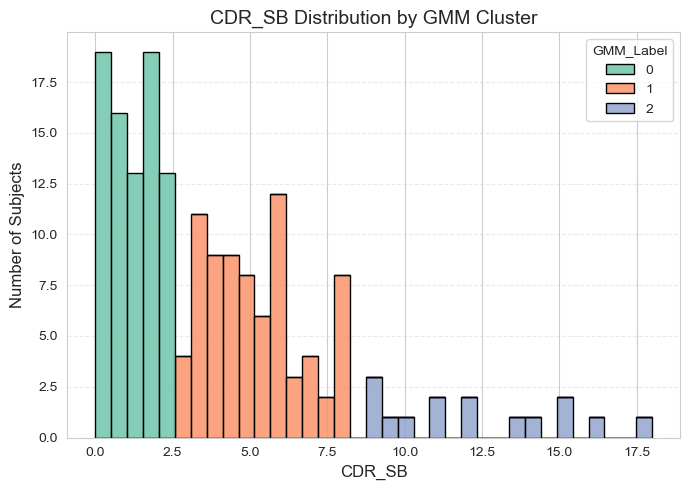

In [27]:
plt.figure(figsize=(7, 5))
sns.histplot(
    data=df_meta.dropna(subset=['CDR_SB', 'GMM_Label']),
    x='CDR_SB',
    hue='GMM_Label',
    palette='Set2',
    multiple='stack',   # oppure 'dodge' per barre affiancate
    bins=35,
    edgecolor='black',
    alpha=0.8
)

plt.xlabel("CDR_SB", fontsize=12)
plt.ylabel("Number of Subjects", fontsize=12)
plt.title("CDR_SB Distribution by GMM Cluster", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

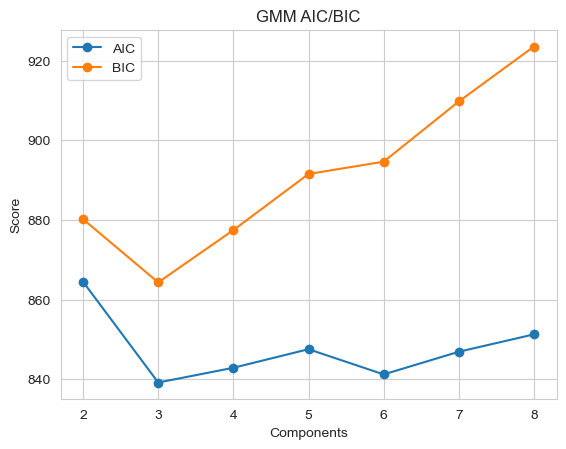

In [28]:
aic, bic = evaluate_gmm(x_gmm, K_range=range(2, 9), save_path= None, prefix="cdr_sb", plot_flag=True)

## Yeo Data

In [29]:
df_networks_no_thr = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_noTHR.csv")
df_networks_thr01 = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_thr01.csv")
df_networks_thr02 = pd.read_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/data/mean_networks/mean_networks_thr02.csv")

In [30]:
df_networks_no_thr = df_networks_no_thr.rename(columns={"CODE": "ID"})
df_networks_thr01 = df_networks_thr01.rename(columns={"CODE": "ID"})
df_networks_thr02 = df_networks_thr02.rename(columns={"CODE": "ID"})

In [31]:
features_network = ['VIS_mean', 'VAN_mean', 'DAN_mean', 'DMN_mean', 'LMB_mean', 'FPN_mean', 'SMN_mean', 'SUBCORTICAL_mean']

# Analysis with UMAP

## Data

### Load data

Recall the dataframe with ID and values of the maps

In [32]:
print("\n", df.shape, "\n")
df.iloc[:5, :5]


 (176, 902630) 



,ID,0,1,2,3
0,002_S_4654,0.0,0.0,0.0,0.0
1,002_S_6695,0.0,0.0,0.0,0.0
2,003_S_6264,0.0,0.0,0.0,0.0
3,003_S_6268,0.0,0.0,0.0,0.0
4,003_S_6432,0.0,0.0,0.0,0.0


Merging the meta columns with the above dataframe: the order of the subject must be the same of the dataframe of the FC maps

In [33]:
df_meta = df_meta.set_index('ID').loc[df['ID']].reset_index()

assert all(df['ID'] == df_meta['ID']), "Mismatch between ID of df and df_meta_ordered"
print("The ID are now perfectly aligned")

The ID are now perfectly aligned


### Preprocessing

In [34]:
df.shape

(176, 902630)

#### Thresholding

Set a threshold for values below 0.1 and 0.2 for defining correlation

In [35]:
def apply_threshold(dataframe, threshold):
    df_thr = dataframe.copy()
    df_thr.iloc[:, 1:] = df_thr.iloc[:, 1:].mask(df_thr.iloc[:, 1:] < threshold, 0)
    return df_thr

In [36]:
df_thr_01 = apply_threshold(df, threshold=0.1)

In [37]:
df_thr_02 = apply_threshold(df, threshold=0.2)

#### GM Mask

- Binary mask of grey matter using the Harvard-Oxford Atlas

- Keeping the Gray Matter voxels

In [38]:
def apply_mask(df_thr, mask_path):
    # Load and flatten GM mask
    mask = nib.load(mask_path).get_fdata().flatten()
    assert mask.shape[0] == df_thr.shape[1] - 1, "Mask and data length mismatch"

    # Mask
    voxel_data = df_thr.iloc[:, 1:]
    voxel_data_masked = voxel_data.loc[:, mask != 0]

    # Return the masked dataframes
    df_masked = pd.concat([df_thr[['ID']], voxel_data_masked], axis=1)
    df_masked.columns = ['ID'] + list(range(voxel_data_masked.shape[1]))
    return df_masked

In [39]:
# GM masking
# 0.1 threshold
df_thr01_gm_masked = apply_mask(df_thr_01, gm_mask_path)

# 0.2 threshold
df_thr02_gm_masked = apply_mask(df_thr_02, gm_mask_path)

# Without threshold
df_gm_masked = apply_mask(df, gm_mask_path)

In [40]:
# Harvard masking
# 0.1 threshold
df_thr01_har_masked = apply_mask(df_thr_01, harvard_oxford_mask_path)

# 0.2 threshold
df_thr02_har_masked = apply_mask(df_thr_02, harvard_oxford_mask_path)

# Without
df_har_masked = apply_mask(df, harvard_oxford_mask_path)

### EDA

In [41]:
print("Dimensions of dataframes after gm masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_gm_masked.shape)
print("0.2 threshold", df_thr02_gm_masked.shape)

print("\nDimensions of dataframes after harvard masking with 2 different thresholds:")
print("0.1 threshold", df_thr01_har_masked.shape)
print("0.2 threshold", df_thr02_har_masked.shape)

print("\nDimensions of dataframes after gm masking and harvard masking without thresholding:")
print("GM Mask", df_gm_masked.shape)
print("Harvard Mask", df_har_masked.shape)

Dimensions of dataframes after gm masking with 2 different thresholds:
0.1 threshold (176, 161818)
0.2 threshold (176, 161818)

Dimensions of dataframes after harvard masking with 2 different thresholds:
0.1 threshold (176, 55005)
0.2 threshold (176, 55005)

Dimensions of dataframes after gm masking and harvard masking without thresholding:
GM Mask (176, 161818)
Harvard Mask (176, 55005)


In [42]:
def summarize_voxel_data(df_masked, threshold=None):
    summary = {}
    summary['Shape'] = df_masked.shape

    if threshold:
        has_low = ((df_masked.iloc[:, 1:] > 0) & (df_masked.iloc[:, 1:] < threshold)).any().any()
        summary['Valori tra 0 e threshold'] = has_low
    else:
        summary['Valori tra 0 e threshold'] = 'N/A'

    zero_rows = (df_masked.iloc[:, 1:] == 0).all(axis=1).sum()
    summary['Zero maps'] = f"{zero_rows} su {df_masked.shape[0]}"

    voxel_data = df_masked.iloc[:, 1:].values
    nonzero_voxels = voxel_data[voxel_data != 0]

    summary['All Min'] = voxel_data.min()
    summary['All Max'] = voxel_data.max()
    summary['All Mean'] = voxel_data.mean()
    summary['All Std'] = voxel_data.std()

    summary['Nonzero Min'] = nonzero_voxels.min()
    summary['Nonzero Max'] = nonzero_voxels.max()
    summary['Nonzero Mean'] = nonzero_voxels.mean()
    summary['Nonzero Std'] = nonzero_voxels.std()

    return summary

In [43]:
# Dataset
dataframes = {
    "thr_01_gm": (df_thr01_gm_masked, 0.1),
    "thr_02_gm": (df_thr02_gm_masked, 0.2),
    "thr_01_har": (df_thr01_har_masked, 0.1),
    "thr_02_har": (df_thr02_har_masked, 0.2),
    "gm_no_thr": (df_gm_masked, None),
    "har_no_thr": (df_har_masked, None)
}

# Functions
results = []

for name, (dfm, thr) in dataframes.items():
    summary = summarize_voxel_data(dfm, threshold=thr)
    summary['Dataset'] = name
    results.append(summary)

# Summary
df_summary = pd.DataFrame(results).set_index('Dataset')
pd.options.display.float_format = '{:.4f}'.format

In [44]:
print("Summary of voxel data:")
display(df_summary)

Summary of voxel data:


,Shape,Valori tra 0 e threshold,Zero maps,All Min,All Max,All Mean,All Std,Nonzero Min,Nonzero Max,Nonzero Mean,Nonzero Std
Dataset,,,,,,,,,,,
thr_01_gm,"(176, 161818)",False,0 su 176,0.0000,1.6188,0.0736,0.1022,0.1000,1.6188,0.1829,0.0771
thr_02_gm,"(176, 161818)",False,0 su 176,0.0000,1.6188,0.0343,0.0943,0.2000,1.6188,0.2750,0.0715
thr_01_har,"(176, 55005)",False,0 su 176,0.0000,1.6188,0.0846,0.1068,0.1000,1.6188,0.1867,0.0783
thr_02_har,"(176, 55005)",False,8 su 176,0.0000,1.6188,0.0412,0.1022,0.2000,1.6188,0.2754,0.0723
gm_no_thr,"(176, 161818)",N/A,0 su 176,-0.2879,1.6188,0.1000,0.0871,-0.2879,1.6188,0.1000,0.0871
har_no_thr,"(176, 55005)",N/A,0 su 176,-0.1555,1.6188,0.1086,0.0916,-0.1555,1.6188,0.1086,0.0916


### Input Data

For the further analysis we will remove the ID labels columns, but the order is mantained.

Possible dataset from mean maps:
- `df_thr01_gm_masked`
- `df_thr02_gm_masked`
- `df_thr01_har_masked`
- `df_thr02_har_masked`
- `df_gm_masked`
- `df_har_masked`

Possible dataset from mean network:
- `df_networks_no_thr`
- `df_networks_thr01`
- `df_networks_thr02`

Here we go with one example

In [45]:
def features_merging(df_voxel, df_labels):
    # Meta columns
    meta_columns = list(df_labels.columns)

    # Merge based on subject ID
    dataframe_merge = pd.merge(df_voxel, df_labels, on='ID', how='left', validate='one_to_one')

    # Reorder columns: metadata first, then voxel features
    ordered_cols = meta_columns + [col for col in dataframe_merge.columns if col not in meta_columns]
    dataframe_merge = dataframe_merge[ordered_cols]

    # Sanity check to ensure row alignment
    assert (dataframe_merge['ID'].values == df_voxel['ID'].values).all(), "Row order mismatch after merge"

    # Extract features only (drop metadata)
    x = dataframe_merge.drop(columns=meta_columns)

    return dataframe_merge, x

In [46]:
df_merged, X = features_merging(df_gm_masked, df_meta)

In [47]:
X.shape

(176, 161817)

## Dimensionality Reduction

UMAP is not changing the order of the rows so each row correspond to the previous subject in the not reduced dataset.

In [48]:
np.random.seed(42)

In [49]:
umap_params = {'n_neighbors': 15, 'n_components': 2, 'metric': 'euclidean', 'n_epochs': 1000, 'learning_rate': 1.0, 'init': 'spectral', 'min_dist': 0.1, 'spread': 1.0, 'low_memory': False, 'set_op_mix_ratio': 1.0, 'local_connectivity': 1, 'repulsion_strength': 1.0, 'negative_sample_rate': 5, 'transform_queue_size': 4.0, 'a': None, 'b': None, 'random_state': 42, 'metric_kwds': None, 'angular_rp_forest': False, 'target_n_neighbors': -1, 'transform_seed': 42, 'verbose': False, 'unique': False}

In [50]:
# Parameters
reducer = umap.UMAP(**umap_params)

# Fit the model
X_umap = reducer.fit_transform(X)

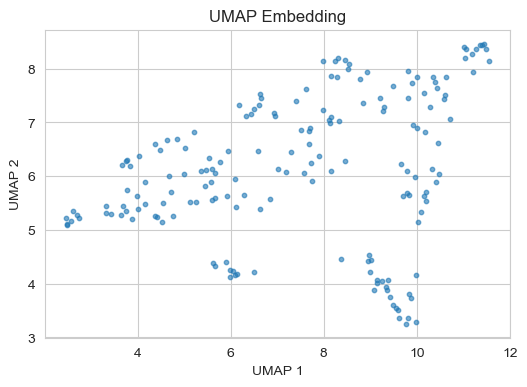

In [51]:
plt.figure(figsize=(6, 4))
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=10, alpha=0.6)
plt.title("UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True)
plt.show()

## Unsupervised Clustering

### Fit models

In [52]:
# HDBSCAN
cluster_hdb = hdbscan.HDBSCAN(min_cluster_size=5)
labels_hdb = cluster_hdb.fit_predict(X_umap)

# DBSCAN
clusterer_db = DBSCAN(eps=0.5, min_samples=5)
labels_db = clusterer_db.fit_predict(X_umap)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
labels_km = kmeans.fit_predict(X_umap)

# GMM
gmm = GaussianMixture(n_components=3, random_state=42)
labels_gmm = gmm.fit_predict(X_umap)

Result collection

In [53]:
labels_dict = {
    "HDBSCAN": labels_hdb,
    "DBSCAN": labels_db,
    "K-Means": labels_km,
    "GMM": labels_gmm
}

In [54]:
labels_df = pd.DataFrame({
    'ID': df_merged['ID'],
    'Group': df_merged['Group'],
    'CDR_SB': df_merged['CDR_SB'],
    'MMSE': df_merged['MMSE'],
    'GMM_Label': df_merged['GMM_Label'],
    'HDBSCAN': labels_hdb,
    'DBSCAN': labels_db,
    'KMeans': labels_km,
    'GMM': labels_gmm
})

#labels_df.to_csv("/Users/emmatosato/Documents/PhD/ANM_Verona/utils/clustering_labels_by_ID.csv", index=False)

In [55]:
# HDBSCAN optimal clusters
labels_hdb, n_hdb = evaluate_hdbscan(X_umap, min_cluster_size=5)

HDBSCAN found 11 clusters (excluding noise)


### Optimal number of clusters

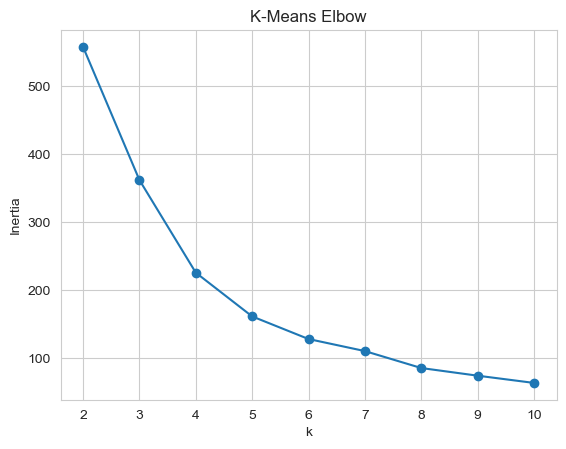

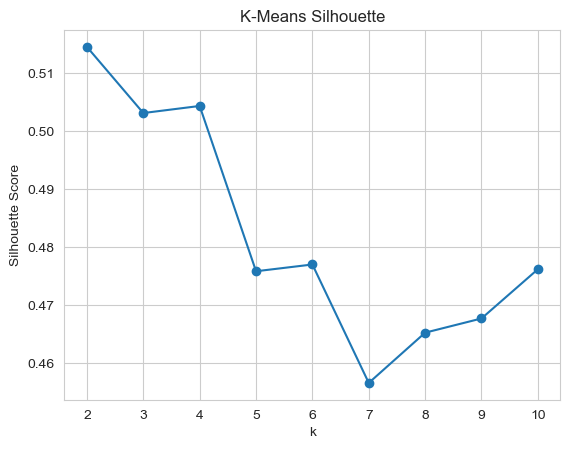

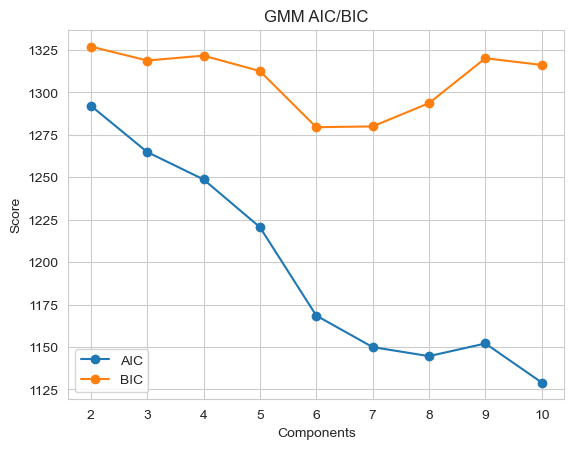

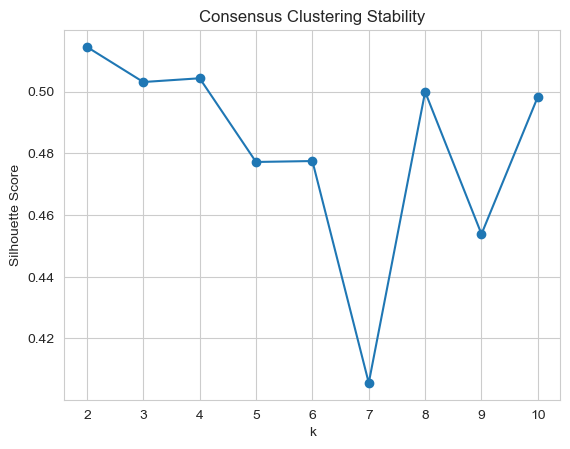

In [56]:
# K-Means optimal clusters
inertias, sil_scores = evaluate_kmeans(
    X_umap,
    K_range=range(2, 11),
    save_path=None,
    prefix= "gm02",
    plot_flag=True
)

# GMM optimal clusters
aic, bic = evaluate_gmm(
    X_umap,
    K_range=range(2, 11),
    save_path=None,
    prefix="gm02",
    plot_flag=True
)

# Consenus clustering
stability_scores = evaluate_consensus(
    X_umap,
    K_range=range(2, 11),
    n_runs=100,
    save_path=None,
    prefix='gm02',
    plot_flag=True
)

### Plotting

In [57]:
def plot_clusters_vs_labels(x_umap, labels_dictionary, label_source_df, label_column, figsize=(16, 24), margin=5):
    n = len(labels_dictionary)
    n_cols = 2
    n_rows = n

    x_min, x_max = x_umap[:, 0].min() - margin, x_umap[:, 0].max() + margin
    y_min, y_max = x_umap[:, 1].min() - margin, x_umap[:, 1].max() + margin

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for i, (title, labels) in enumerate(labels_dictionary.items()):
        ax_left = axes[i, 0]
        ax_right = axes[i, 1]

        plot_df = pd.DataFrame({
            'X1': x_umap[:, 0],
            'X2': x_umap[:, 1],
            'cluster': labels,
            'label': label_source_df[label_column].reset_index(drop=True)
        })

        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='cluster', palette='Set1', s=50, ax=ax_left, legend='full')
        ax_left.set_title(f'{title} - Clustering')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_xlabel("UMAP 1")
        ax_left.set_ylabel("UMAP 2")

        sns.scatterplot(data=plot_df, x='X1', y='X2', hue='label', palette='Set2', s=50, ax=ax_right, legend='full')
        ax_right.set_title(f'{title} - {label_column}')
        ax_right.set_xlim(x_min, x_max)
        ax_right.set_ylim(y_min, y_max)
        ax_right.set_xlabel("UMAP 1")
        ax_right.set_ylabel("UMAP 2")

    plt.tight_layout()
    plt.show()

In [58]:
#plot_clusters_vs_labels(X_umap, labels_dict, df_merged, label_column='GMM_Label', margin=2.5)

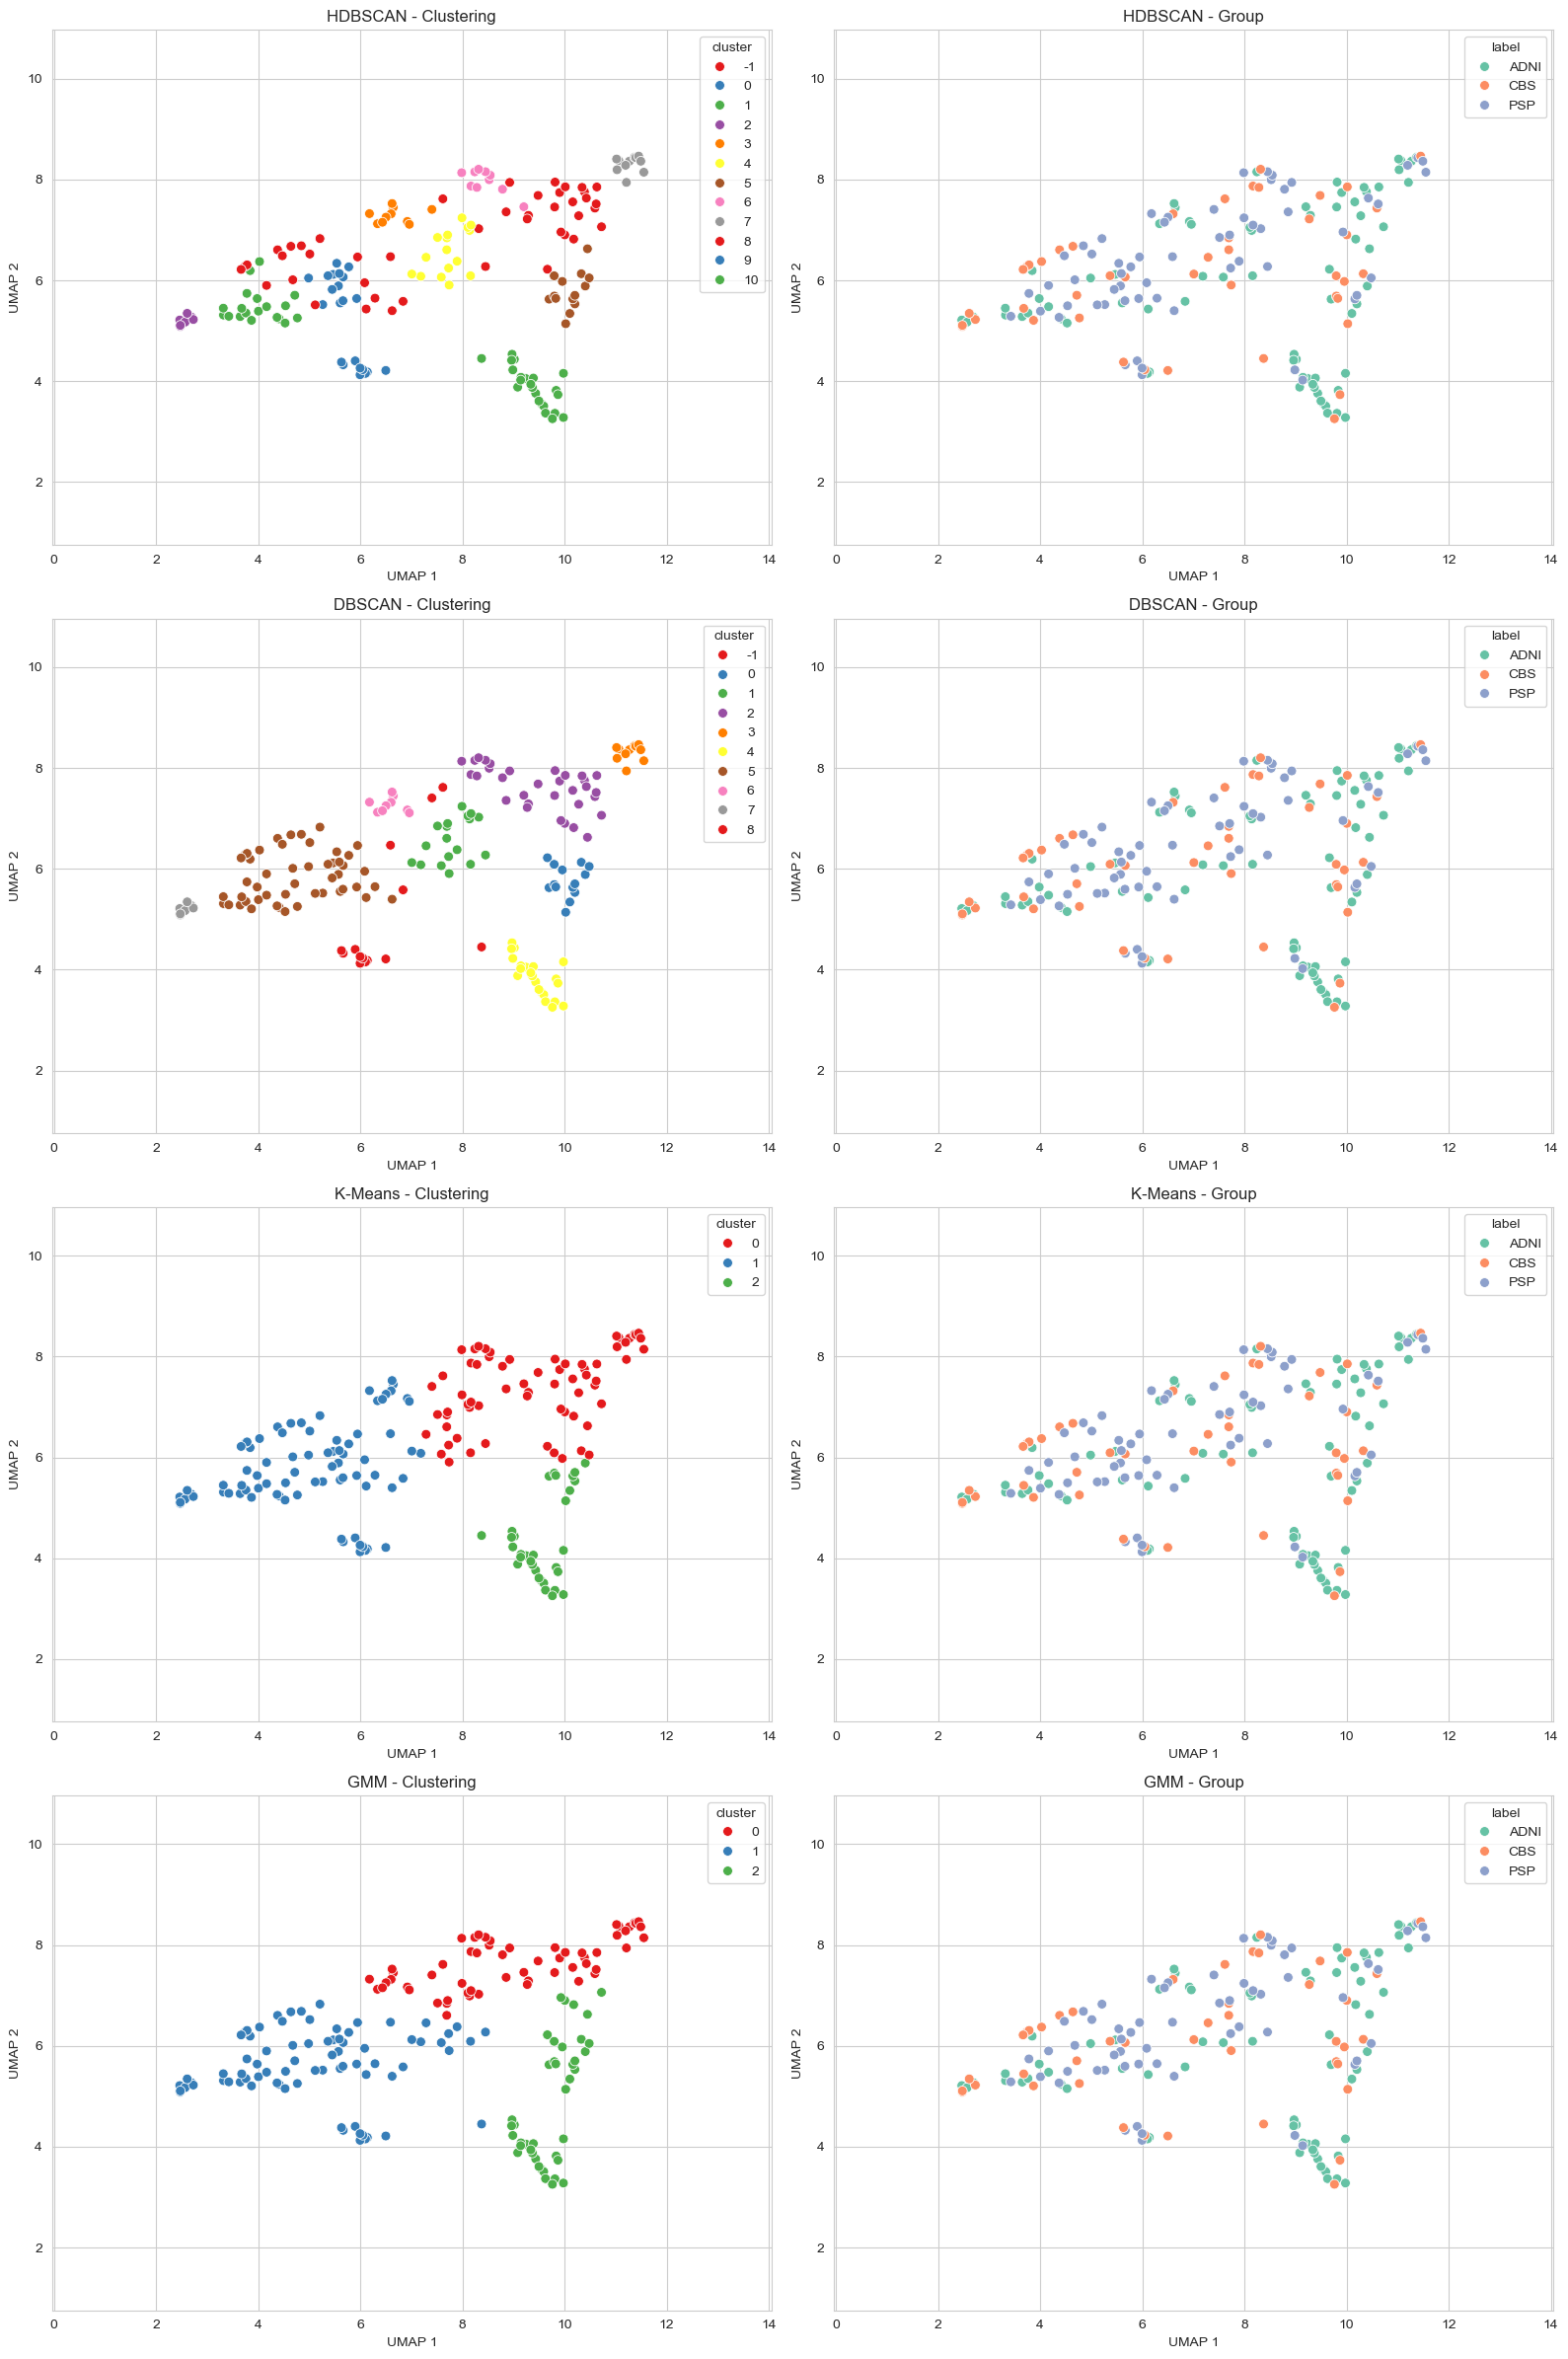

In [59]:
plot_clusters_vs_labels(X_umap, labels_dict, df_merged, label_column='Group', margin=2.5)

### Statistical Evaluation

Do clusters separate diagnoses?

In [60]:
methods = ['KMeans', 'HDBSCAN']
diagnosis_col = 'Group'

for method in methods:
    print(f"\n=== {method} ===")

    # Contingency table
    contingency = pd.crosstab(labels_df[method], labels_df[diagnosis_col])

    # Chi-squared test
    chi2, p_value, dof, expected = chi2_contingency(contingency)

    print(f"Chi² = {chi2:.4f}")
    print(f"p-value = {p_value:.4f}")
    print(f"Degrees of Freedom = {dof}")
    print("Contingency Table:")
    print(contingency)

    # Silhouette Score
    labels = labels_df[method]
    n_clusters = len(np.unique(labels))
    if n_clusters > 1:
        sil_score = silhouette_score(X_umap, labels)
        print(f"Silhouette Score = {sil_score:.4f}")
    else:
        print("Silhouette Score not computed: only one cluster found.")


=== KMeans ===
Chi² = 13.9139
p-value = 0.0076
Degrees of Freedom = 4
Contingency Table:
Group   ADNI  CBS  PSP
KMeans                
0         25   17   24
1         25   21   32
2         22    6    4
Silhouette Score = 0.5031

=== HDBSCAN ===
Chi² = 43.1059
p-value = 0.0046
Degrees of Freedom = 22
Contingency Table:
Group    ADNI  CBS  PSP
HDBSCAN                
-1          6    8   17
 0          2    3    4
 1         18    3    2
 2          3    4    0
 3          5    1    4
 4          5    5    6
 5          5    6    3
 6          2    3    5
 7          6    1    4
 8          8    3    2
 9          3    2    8
 10         9    5    5
Silhouette Score = 0.3881


Do the clusters separate subjects by clinical severity (CDR_SB)?

In [61]:
target_col = "CDR_SB"
labels_df = labels_df[labels_df[target_col].notna()].copy()

print(f"Removed NaN in {target_col} → New shape: {labels_df.shape}")

Removed NaN in CDR_SB → New shape: (171, 9)



=== KMeans (filtered) ===

CDR_SB group statistics:
         count   mean    std    min    25%    50%    75%     max
KMeans                                                          
0      64.0000 3.3125 2.7509 0.0000 1.0000 2.5000 5.5000 12.0000
1      75.0000 4.5267 3.8317 0.0000 2.0000 3.5000 6.0000 18.0000
2      32.0000 4.4844 3.5435 0.0000 2.0000 4.0000 5.6250 15.0000

Kruskal-Wallis test: statistic = 4.4546, p = 0.1078


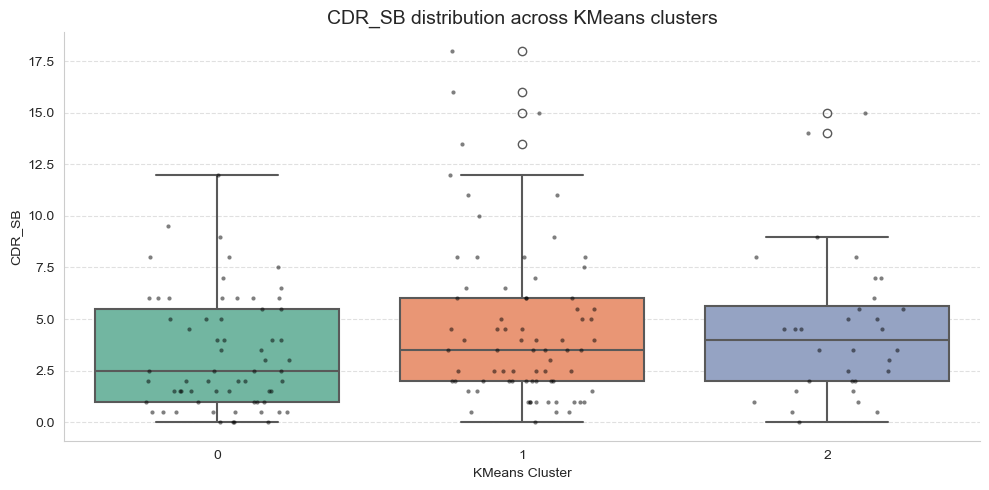


=== HDBSCAN (filtered) ===

CDR_SB group statistics:
          count   mean    std    min    25%    50%    75%     max
HDBSCAN                                                          
-1      29.0000 4.3103 4.3186 0.5000 1.5000 3.5000 6.0000 18.0000
 1      23.0000 5.0652 3.8739 0.0000 2.2500 4.5000 7.0000 15.0000
 4      15.0000 3.2333 2.8022 0.0000 1.0000 2.5000 4.7500  9.0000
 5      13.0000 3.0385 2.1356 0.5000 1.0000 3.5000 5.0000  6.0000
 6      10.0000 4.7000 2.8008 0.5000 3.0000 5.5000 6.0000  9.5000
 7      11.0000 1.8636 2.1106 0.0000 0.5000 1.5000 2.5000  7.5000
 8      13.0000 2.5385 2.0763 0.5000 1.0000 2.0000 4.5000  6.0000
 9      13.0000 4.8846 3.3488 1.5000 2.5000 4.0000 6.5000 13.5000
 10     19.0000 3.7632 2.7707 0.5000 1.5000 3.5000 4.7500 10.0000

Kruskal-Wallis test: statistic = 15.1946, p = 0.0555


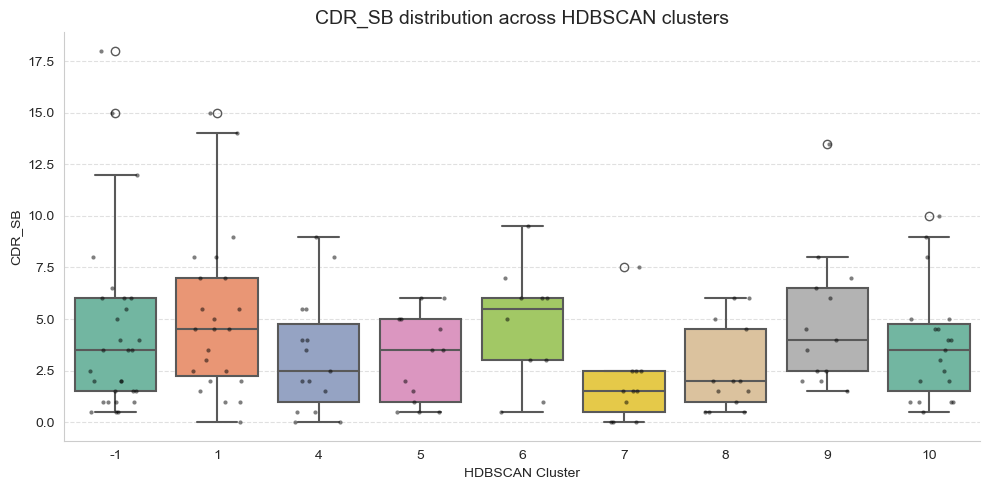

In [62]:
for method in ['KMeans', 'HDBSCAN']:
    print(f"\n=== {method} (filtered) ===")

    # Filter clusters with at least 10 subjects
    cluster_sizes = labels_df[method].value_counts()
    valid_clusters = cluster_sizes[cluster_sizes >= 10].index
    filtered_df = labels_df[labels_df[method].isin(valid_clusters)]

    # Descriptive stats
    print("\nCDR_SB group statistics:")
    print(filtered_df.groupby(method)['CDR_SB'].describe())

    # Kruskal-Wallis test
    groups = [filtered_df[filtered_df[method] == c]['CDR_SB'] for c in valid_clusters]
    stat, p = kruskal(*groups)
    print(f"\nKruskal-Wallis test: statistic = {stat:.4f}, p = {p:.4f}")

    # Post-hoc test
    if p < 0.05:
        print("\nPost-hoc Dunn test (Bonferroni corrected):")
        posthoc = sp.posthoc_dunn(filtered_df, val_col='CDR_SB', group_col=method, p_adjust='bonferroni')
        print(posthoc)

    # Boxplot + stripplot
    plt.figure(figsize=(10, 5))
    sns.boxplot(x=filtered_df[method], y=filtered_df['CDR_SB'], palette="Set2", linewidth=1.5)
    sns.stripplot(x=filtered_df[method], y=filtered_df['CDR_SB'], color='black', size=3, jitter=0.25, alpha=0.5)
    plt.title(f'CDR_SB distribution across {method} clusters', fontsize=14)
    plt.xlabel(f'{method} Cluster')
    plt.ylabel('CDR_SB')
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    sns.despine()
    plt.tight_layout()
    plt.show()


## Linear Regression
- Select dataframe and target variable
- OLS
- Plot
- Shuffling

### Example


In [63]:
# Remove subjects with NaN values
target_col = "CDR_SB"
df = remove_missing_values(df_gm_masked, df_meta, target_col)

print("New shape: ", df.shape)

New shape:  (171, 161818)


In [64]:
# Features
df_merged, X = features_merging(df, df_meta)

# UMAP
reducer = umap.UMAP(**umap_params)
X_umap = reducer.fit_transform(X)

# Target
y = df_merged[target_col]

# Add constant (intercept)
X_with_const = sm.add_constant(X_umap)

# Fit OLS
model = sm.OLS(y, X_with_const).fit()

# Predictions and residuals
y_pred = model.predict(X_with_const)
residuals = y - y_pred

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     7.707
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           0.000628
Time:                        18:05:42   Log-Likelihood:                -445.84
No. Observations:                 171   AIC:                             897.7
Df Residuals:                     168   BIC:                             907.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5135      1.161      7.332      0.0

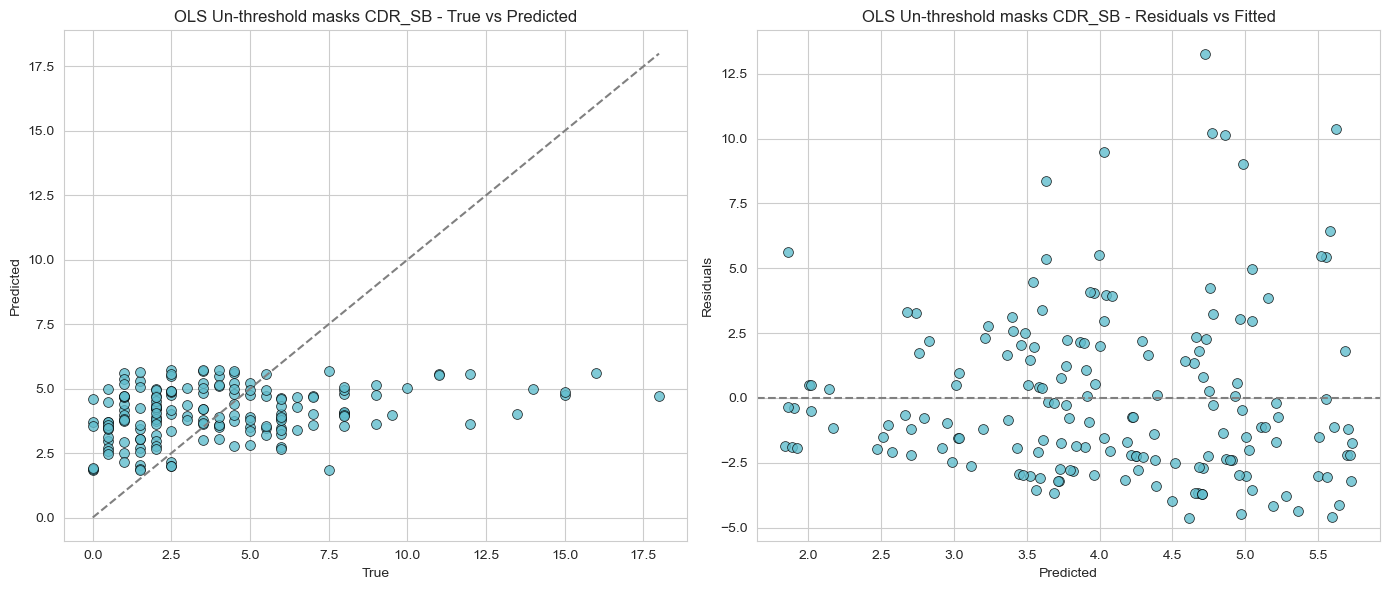

In [65]:
plot_ols_diagnostics(y, y_pred, residuals, "OLS Un-threshold masks CDR_SB",save_path=None, plot_flag=True)

In [67]:
# Merge: reti + metadati
df_merged = pd.merge(df_gm_masked, df_meta, on='ID', how='inner')

# Seleziona solo soggetti con CDR_SB valido
df_mean_regression = df_merged[df_merged['CDR_SB'].notna()].copy()

# Outcome variable
y = df_mean_regression['CDR_SB']

# Prepare design matrix X
non_voxel_cols = ['ID', 'Group', 'Sex', 'Age', 'Education', 'CDR_SB', 'MMSE', 'GMM_Label']
X = df_mean_regression.drop(columns=non_voxel_cols, errors='ignore')

#UMAP
reducer = umap.UMAP(**umap_params)
X_umap = reducer.fit_transform(X)

# Add intercept
X_umap = sm.add_constant(X_umap)

# Regressione OLS
model = sm.OLS(y, X_umap)
results = model.fit()

# Print model summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     7.707
Date:                Tue, 03 Jun 2025   Prob (F-statistic):           0.000628
Time:                        18:06:47   Log-Likelihood:                -445.84
No. Observations:                 171   AIC:                             897.7
Df Residuals:                     168   BIC:                             907.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5135      1.161      7.332      0.0

Shuffling Regression

In [ ]:
# R² real
r2_real = model.rsquared

# List of R² after shuffling
r2_shuffled = []

for _ in range(100):
    y_shuffled = y.sample(frac=1, replace=False, random_state=None).reset_index(drop=True)
    model_shuffled = sm.OLS(y_shuffled, X_with_const).fit()
    r2_shuffled.append(model_shuffled.rsquared)

# empiric p-value
p_value = np.mean([r >= r2_real for r in r2_shuffled])

print(f"R² real: {r2_real:.4f}")
print(f"R² shuffled: {np.mean(r2_shuffled):.4f}")
print(f"p-value (shuffling): {p_value:.4f}")

### GMM distributions

In [ ]:
for gmmLabel in range(0,3):
    mean_cdr = df_meta.loc[df_meta['GMM_Label'] == gmmLabel, 'CDR_SB'].mean()
    print(f"Media CDR_SB per gruppo {gmmLabel}: {mean_cdr:.3f}")

In [ ]:
target_col = "CDR_SB"
label_col = "GMM_Label"

# Loop over each GMM cluster
for gmm_label in df_meta[label_col].dropna().unique():
    print(f"\n=== GMM Cluster {gmm_label} ===")

    # Get IDs for the current cluster
    ids_in_cluster = df_meta[df_meta[label_col] == gmm_label]["ID"]

    # Filter metadata and remove missing target values
    df_meta_cluster = df_meta[df_meta["ID"].isin(ids_in_cluster)].reset_index(drop=True)
    df_meta_cluster = df_meta_cluster[df_meta_cluster[target_col].notna()]

    # Filter voxel data accordingly
    df_cluster = df_thr02_har_masked[df_thr02_har_masked["ID"].isin(df_meta_cluster["ID"])].reset_index(drop=True)

    # Run regression
    model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
        df_masked = df_cluster,
        df_meta = df_meta_cluster,
        target_variable = target_col,
        covariates = None,
        y_log_transform = False,
        plot_flag = True,
        save_path = None,
        title_prefix = f"gm_mask_GMM_{gmm_label}"
    )

### Cluster K-Means


=== Cluster 0 ===
Dataframe shape after merge: (64, 161825)
Meta columns: 8
Feature matrix shape: (64, 161817) 



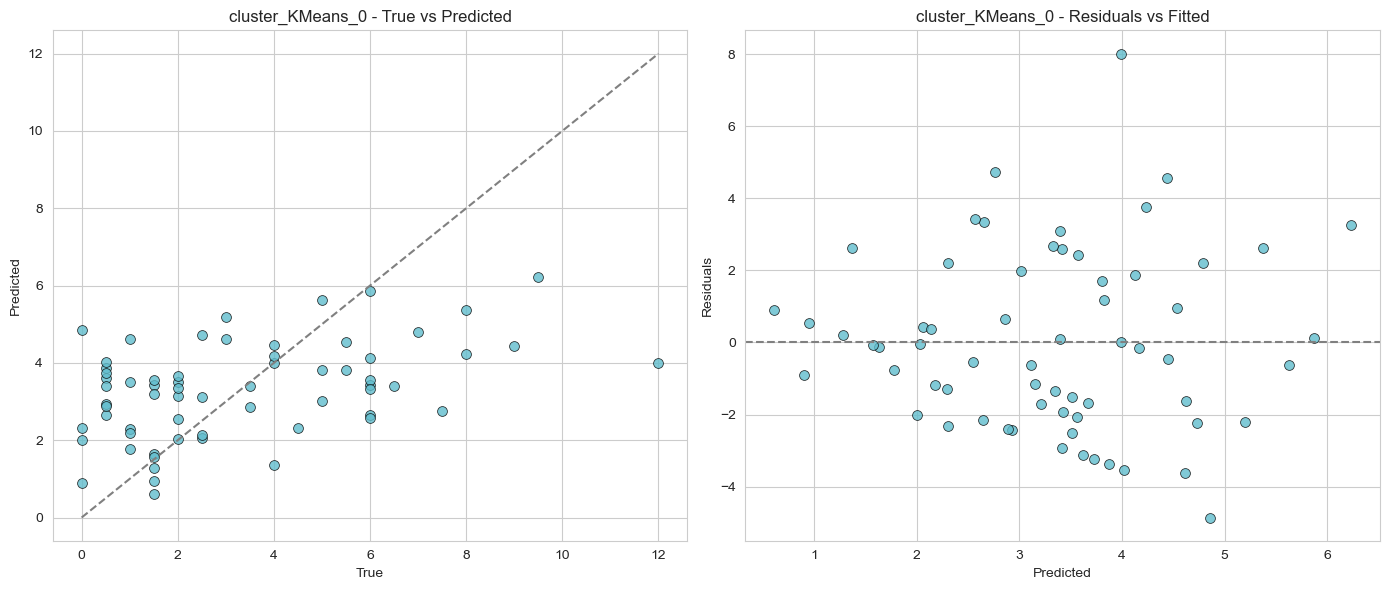

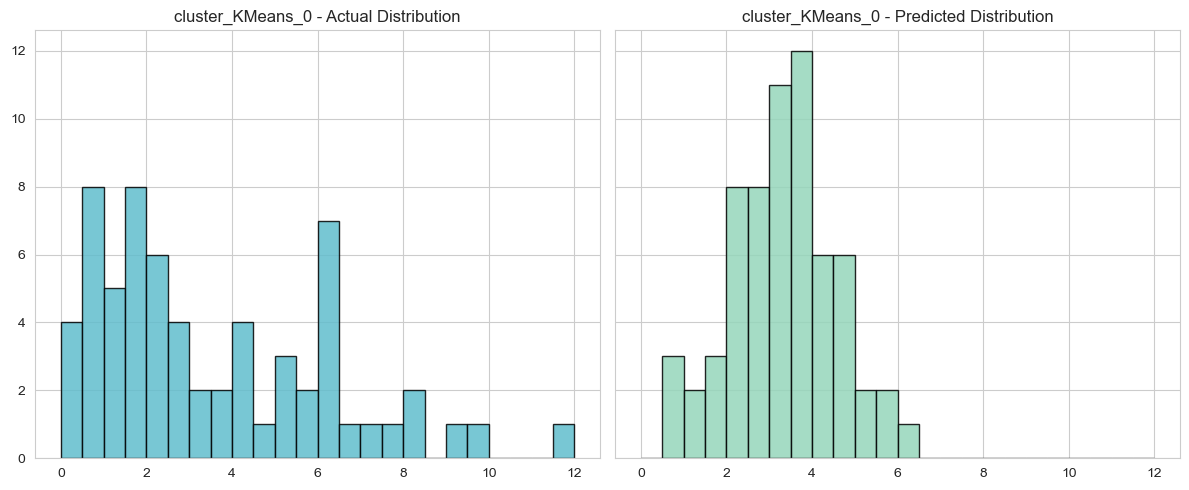

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     2.920
Date:                Tue, 03 Jun 2025   Prob (F-statistic):             0.0203
Time:                        18:13:37   Log-Likelihood:                -147.89
No. Observations:                  64   AIC:                             307.8
Df Residuals:                      58   BIC:                             320.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4836      4.975     -0.298      0.7

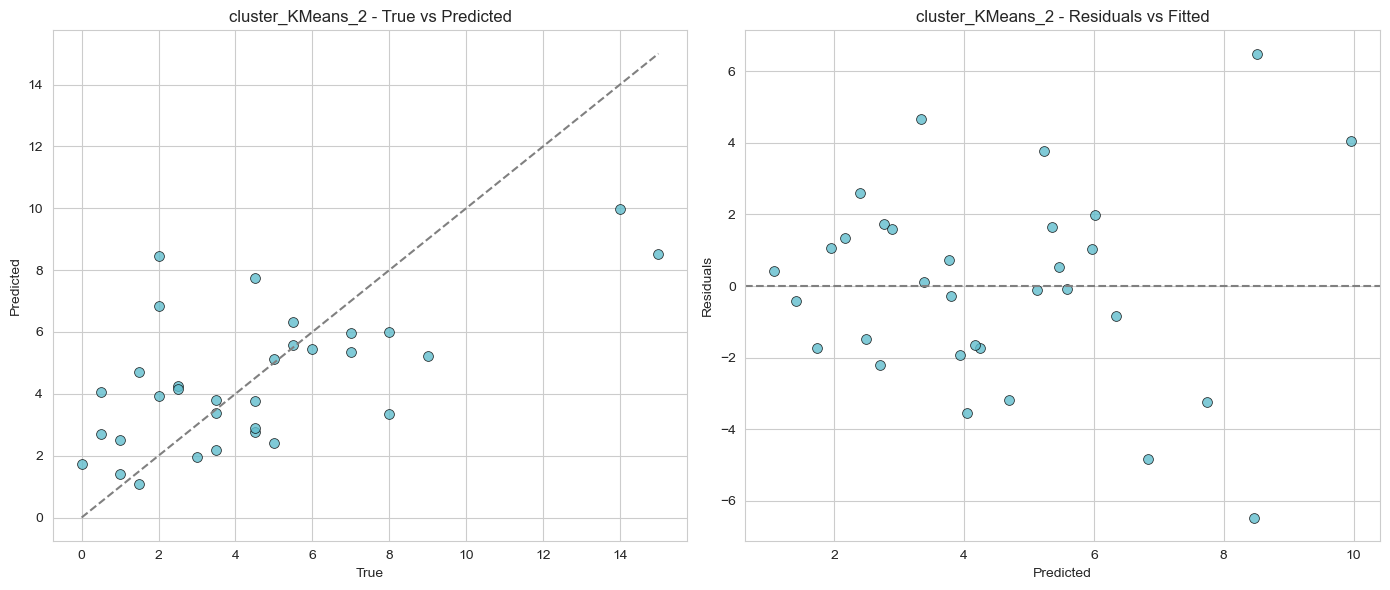

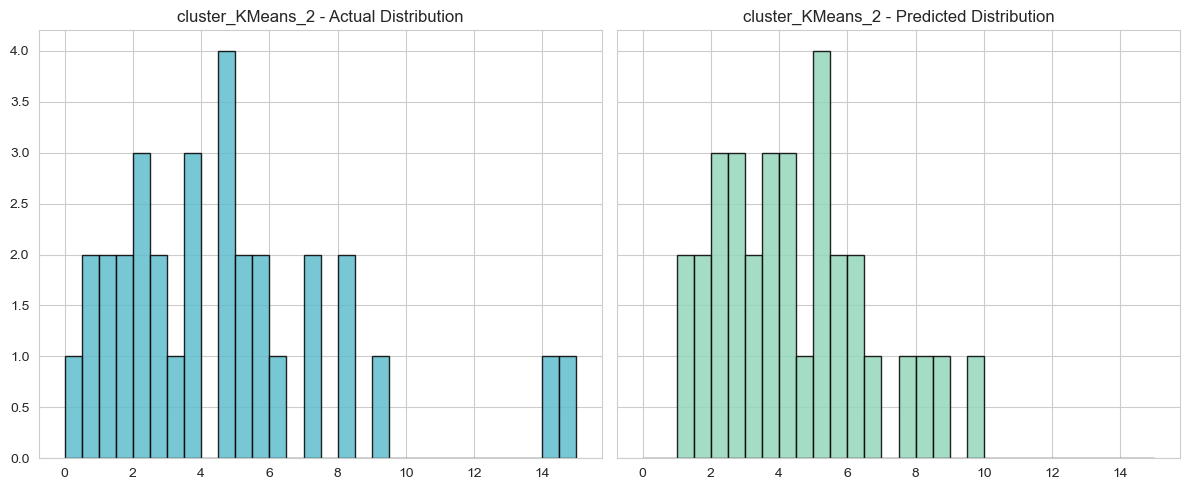

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     3.321
Date:                Tue, 03 Jun 2025   Prob (F-statistic):             0.0188
Time:                        18:13:38   Log-Likelihood:                -77.479
No. Observations:                  32   AIC:                             167.0
Df Residuals:                      26   BIC:                             175.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.1833     14.338     -2.035      0.0

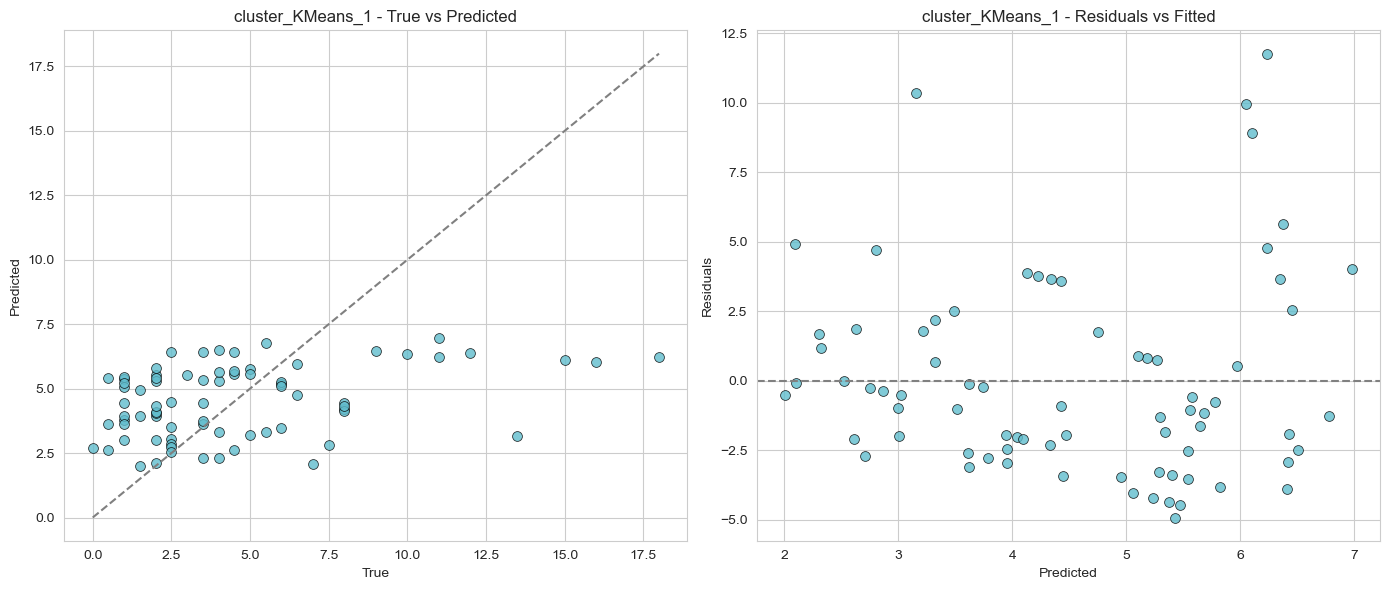

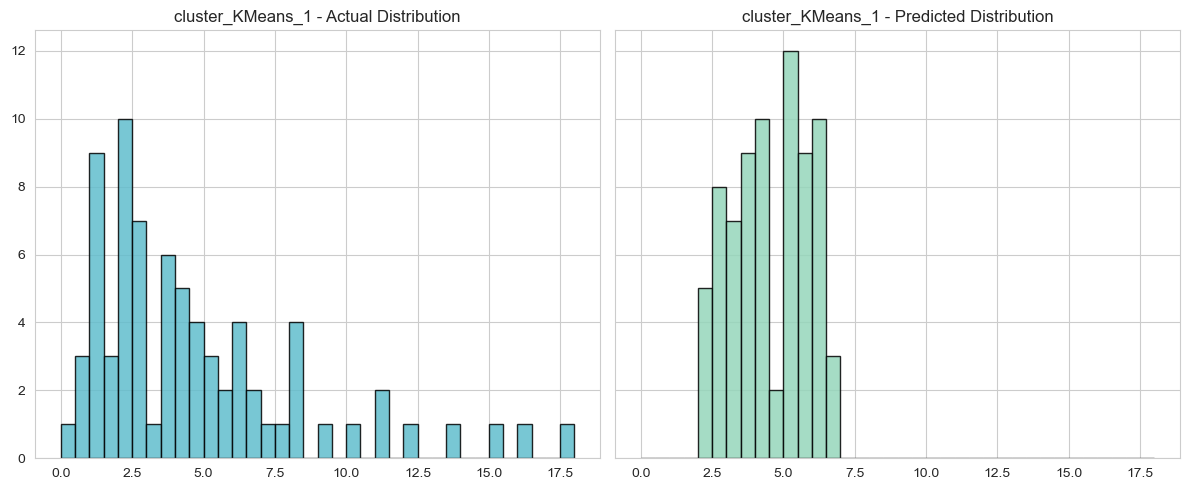

                            OLS Regression Results                            
Dep. Variable:                 CDR_SB   R-squared:                       0.128
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     2.017
Date:                Tue, 03 Jun 2025   Prob (F-statistic):             0.0869
Time:                        18:13:40   Log-Likelihood:                -201.55
No. Observations:                  75   AIC:                             415.1
Df Residuals:                      69   BIC:                             429.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1635      6.007      0.860      0.3

In [68]:
target_col = "CDR_SB"
cluster_col = "KMeans"

for cluster_id in labels_df[cluster_col].unique():
    print(f"\n=== Cluster {cluster_id} ===")

    # Get subject IDs for the current cluster
    ids_in_cluster = labels_df[labels_df[cluster_col] == cluster_id]["ID"]

    # Filter df_meta and df_gm_masked based on IDs only
    df_meta_cluster = df_meta[df_meta["ID"].isin(ids_in_cluster)].reset_index(drop=True)
    df_cluster = df_gm_masked[df_gm_masked["ID"].isin(ids_in_cluster)].reset_index(drop=True)

    # Run regression (NaN removal is handled internally)
    model, y_pred, residuals, subject_errors, group_rmse_stats = main_regression(
        df_masked = df_cluster,
        df_meta = df_meta_cluster,
        target_variable = target_col,
        covariates = ['Sex', 'Age', 'Education'],
        y_log_transform = False,
        plot_flag = True,
        save_path = None,
        title_prefix = f"cluster_{cluster_col}_{cluster_id}"
    )

# CNN

## Data

### Loading

In [ ]:
# Set paths
file_name = "1_S_5005.FDC.nii.gz"

# Load raw image
path_temp = os.path.join(dir_FCmaps, file_name)
img = nib.load(path_temp)
data_raw = img.get_fdata()
affine = img.affine

### Pre-processing

In [ ]:
# Load GM mask
mask = nib.load(gm_mask_path).get_fdata()
mask = mask != 0

# Parameters
threshold = 0.1
apply_normalization = True

# Threshold
data_proc = np.copy(data_raw)
data_proc[data_proc < threshold] = 0

# Masking
data_proc[~mask] = 0

# Normalization
if apply_normalization:
    nonzero = data_proc[data_proc != 0]
    if nonzero.size > 0:
        min_val = nonzero.min()
        max_val = nonzero.max()
        if max_val != min_val:
            data_proc[data_proc != 0] = (data_proc[data_proc != 0] - min_val) / (max_val - min_val)

In [ ]:
# Output path
out_dir = "/Users/emmatosato/Documents/PhD/ANM_Verona"
base_name = file_name.replace('.nii.gz', '')

raw_save_path = os.path.join(out_dir, f"{base_name}.raw.nii.gz")
nii_save_path = os.path.join(out_dir, f"{base_name}.processed01.nii.gz")

# Save as .nii.gz
raw_img = nib.Nifti1Image(data_raw, affine)
nib.save(raw_img, raw_save_path)

proc_img = nib.Nifti1Image(data_proc, affine)
nib.save(proc_img, nii_save_path)

## Analysis

Example of comparison between the raw and processed images

In [ ]:
# --- Paths ---
raw_map_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/1_S_5005.FDC.raw.nii.gz'
processed_map_path = '/Users/emmatosato/Documents/PhD/ANM_Verona/1_S_5005.FDC.processed02.nii.gz'

# --- Load the NIfTI files ---
raw_img = nib.load(raw_map_path).get_fdata()
processed_img = nib.load(processed_map_path).get_fdata()

# --- Flatten the images ---
raw_flat = raw_img.flatten()
processed_flat = processed_img.flatten()

In [ ]:
# --- Compare voxels ---
# 1. Absolute difference
abs_diff = np.abs(raw_flat - processed_flat)

# 2. Mean absolute difference
mean_abs_diff = abs_diff.mean()

# 3. Percentage of voxels that changed
changed_voxels = abs_diff > 1e-6  # Mask of changed voxels
num_changed_voxels = np.sum(changed_voxels)
total_voxels = raw_flat.shape[0]
percentage_changed = (num_changed_voxels / total_voxels) * 100

# 4. Among changed voxels, percentage that became zero
changed_and_now_zero = (processed_flat[changed_voxels] == 0)
percentage_changed_to_zero = (np.sum(changed_and_now_zero) / num_changed_voxels) * 100

In [ ]:
# --- Print results ---
print(f"Mean absolute difference: {mean_abs_diff:.6f}")
print(f"Percentage of voxels changed: {percentage_changed:.2f}%")
print(f"Percentage of changed voxels that became zero: {percentage_changed_to_zero:.2f}%")

In [ ]:
# Find indices of changed voxels
changed_indices = np.where(abs_diff > 1e-6)[0]

# Among changed, select only those that stayed nonzero
stayed_nonzero_indices = changed_indices[processed_flat[changed_indices] != 0]

# Show first examples
num_examples = 10

print("Examples of changed voxels that stayed NONZERO:")
for idx in stayed_nonzero_indices[:num_examples]:
    print(f"Voxel {idx}: {raw_flat[idx]:.6f} → {processed_flat[idx]:.6f}")